# GNN + XAI Standard Pipeline

## Data Preprocessing - Similarity Network Fusion for Tabular Data

sorry i didn't have a dataset so i just downloaded from kaggle: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data

here, im using **similarity network fusion** to build a network representation from tabular data: https://www.nature.com/articles/nmeth.2810


in our projects, were using a kg but im too lazy to get kg dataset

In [1]:
!ls

 Dataset	 '[LINKPRED] GNN + XAI Standard Pipeline.ipynb'
 install_pyg.sh  '[NODE_CLASSIFICATION] GNN + XAI Standard Pipeline.ipynb'
 LICENSE


In [2]:
#stl
import os
import warnings
from tqdm import tqdm

#data handling
import pandas as pd
import numpy as np

#stats|
import scipy
import sklearn
import missingno as mso

#network
import networkx as nx

#vis
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.5)
sns.set_theme()

In [3]:
df = pd.read_csv("Dataset/breast_cancer_wisconsin_kaggle.csv")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


**ids are patients, columns are features**

In [37]:
#labels 
labels = df["diagnosis"]

#remove na, id, labels
df = df[[i for i in df.columns if i not in ["diagnosis", "id", "Unnamed: 32"]]]
df

KeyError: 'diagnosis'

In [5]:
#set categorical labels to labels
from sklearn.preprocessing import LabelEncoder

#encode cat_df
labels = np.array(LabelEncoder().fit_transform(labels))
labels.shape

(569,)

### Similarity Network Fusion for Network Creation

Here, I use gaussian kernel to generate a similarity score between the samples, and use the similarity score as edge weights to the network. I remove self edges and create a threshold for edges to introduce sparsity

In [6]:
from scipy.spatial.distance import pdist, squareform

#using gaussian kernel as similarity score for edges
pairwise_dists = squareform(pdist(df, 'euclidean'))
gauss_kern = np.exp(-pairwise_dists ** 2 / pairwise_dists.std() ** 2)
gauss_kern.shape

(569, 569)

In [7]:
#network creation
G = nx.from_numpy_array(gauss_kern)
G.remove_edges_from(nx.selfloop_edges(G))
print("nodes:", len(G.nodes))
print("edges:", len(G.edges))

nodes: 569
edges: 161596


len: 161596
top 40 percent of edges: 64638.4
range (min, max): (3.189377428081924e-23, 0.999966415494069)
mean: 0.5334002487412506
std: 0.3821035316599838


Text(0.5, 1.0, 'Distribution of all Edges')

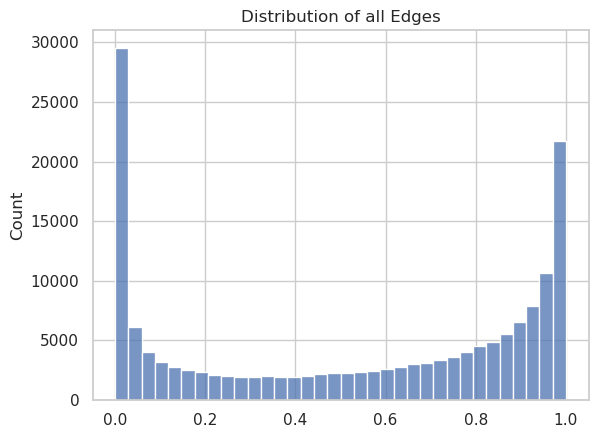

In [8]:
#finding a threshold, top 15% of edge weights
edge_val = [attrs["weight"] for a, b, attrs in G.edges(data=True)]
print("len:", len(edge_val))

percentage = 0.40

print("top 40 percent of edges: %s" % (percentage * len(edge_val)))

print("range (min, max): (%s, %s)" % (min(edge_val), max(edge_val)))
print("mean: %s" % (sum(edge_val) / len(edge_val)))
print("std: %s" % np.array(edge_val).std())

sns.set_style('whitegrid')
sns.histplot(edge_val)
plt.title("Distribution of all Edges")

**ofc, for this dataset, similarity network fusion is shit. we'll just do it anyways**

len: 64638
range (min, max): (0.7721953572673994, 0.999966415494069)
mean: 0.9229606680671001
std: 0.06593111015360162


Text(0.5, 1.0, 'Distribution of Top 15% Edges')

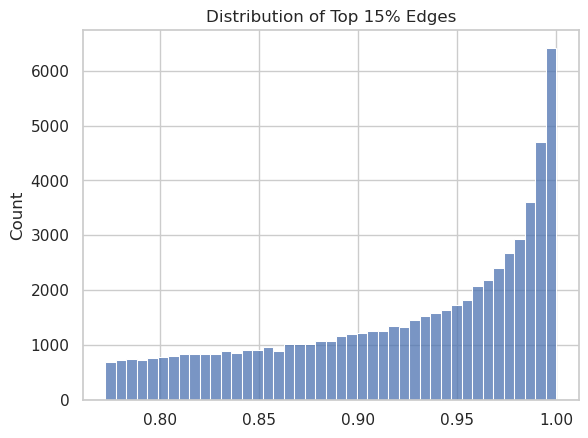

In [9]:
#cut off edges to create a sparse graph. 
ALL_edges = sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
TOP_edges = ALL_edges[(len(edge_val) - int(percentage * len(edge_val))):]
TOP_edge_val = [attrs["weight"] for a, b, attrs in TOP_edges]
print("len:", len(TOP_edge_val))

print("range (min, max): (%s, %s)" % (min(TOP_edge_val), max(TOP_edge_val)))
print("mean: %s" % (sum(TOP_edge_val) / len(TOP_edge_val)))
print("std: %s" % np.array(TOP_edge_val).std())

sns.set_style('whitegrid')
sns.histplot(TOP_edge_val)
plt.title("Distribution of Top 15% Edges")

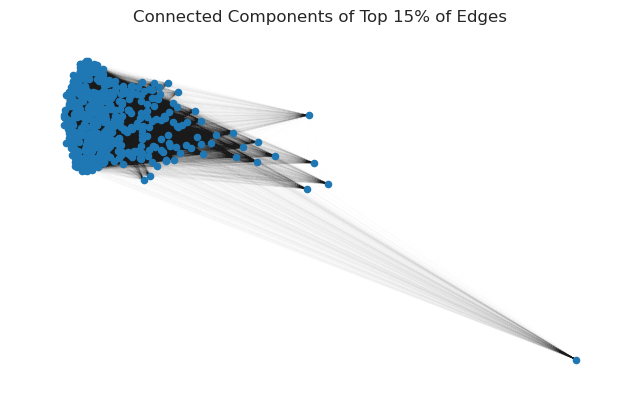

In [10]:
#VISUALIZE
fig = plt.figure(figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(G, seed=10396953)
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.005)
ax.set_title("Connected Components of Top 15% of Edges")
ax.set_axis_off()

network done, node features done, labels done

## Graph Deep Learning! Node Classification

pyg documentation to make own graph from KG: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data

In [11]:
from torch_geometric.utils.convert import from_networkx

g = from_networkx(G)
g

Data(edge_index=[2, 323192], weight=[323192], num_nodes=569)

In [12]:
import torch
#add in node features and labels

#node features
g.x = torch.Tensor(df.to_numpy())

#labels
g.y = torch.Tensor(np.array(labels))
g

Data(edge_index=[2, 323192], weight=[323192], num_nodes=569, x=[569, 30], y=[569])

### Model Creation

In [13]:
#deep learning STL
import torch
import torch.nn.functional as F
from torch.nn import BatchNorm1d 
from torch.nn import Linear

#data loading
from torch_geometric.loader import DataLoader

#parallel
from torch_geometric.nn import DataParallel
from torch_geometric.loader import DataListLoader

#layers
from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn.conv import SAGEConv

#accuracy metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#5 fold CV
from sklearn.model_selection import StratifiedKFold

#collections
import collections 
import collections.abc

#iteration tracking
from tqdm.notebook import tqdm

In [14]:
#GAT with 4 attn heads
class GAT(torch.nn.Module):
        def __init__(self,
                 num_layers,
                 num_heads,
                 node_features = 30,
                 hidden_channels = 64, 
                 out_channels = 1):
    
            super(GAT, self).__init__()

            #storing the layers (you dont have to do this)
            self.module_list = torch.nn.ModuleList([])
            
            self.in_layer = GATConv(in_channels = node_features, out_channels = hidden_channels, heads = num_heads, concat = True)

            #add hidden layers to module list
            for i in range(num_layers):
                self.module_list.append(GATConv(in_channels = hidden_channels * num_heads, out_channels = hidden_channels, heads = num_heads, concat = True))

            self.out_layer = Linear(hidden_channels * num_heads, out_channels)


        def forward(self, x, edge_index):
            
            #layer 1
            x = self.in_layer(x, edge_index).relu()

            #hidden layers
            for i in range(len(self.module_list)):
                x = self.module_list[i](x, edge_index).relu()
                
            #norm
            #x = self.batch_norm(x)

            #linear
            x = self.out_layer(x)

            return x    

### Training Preparation

In [15]:
!nvidia-smi

Mon Mar  4 12:42:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        Off | 00000000:08:00.0  On |                  N/A |
|  0%   28C    P8              35W / 370W |    328MiB / 10240MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
device = torch.device("cuda:0")

### 5-fold Stratified CV with BCE Loss for Binary Classification

In [17]:
#moving to gpu
g = g.to(device)

#model list for 5fold cv, 3 layer GAT with 4 attention heads each
model_list = [GAT(num_layers = 4, num_heads = 2).to(device) for i in range(5)]

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import torchvision

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

epoch_num = 50
threshold = 0.5

for i, (train_index, test_index) in enumerate(skf.split(g.x.cpu(), g.y.cpu())):

    #set model
    model = model_list[i]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epoch_num)
    
    criterion = torch.nn.BCEWithLogitsLoss().to(device)
    
    for i in tqdm(range(epoch_num), desc = "Fold %s" % str(i + 1)):
        
        model.train()
        optimizer.zero_grad()

        #run entire graph through gnn
        out = model(g.x, g.edge_index)
        
        #flatten to match shape, run through BCE focal loss
        #loss only calculated from train nodes
        loss = criterion(out.squeeze()[train_index], g.y[train_index])
        
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()

    probs = torch.sigmoid(out.detach()).cpu().numpy()
    y_preds = (probs >= threshold).astype(int)

    #calculate train accuracy
    accuracy = accuracy_score(y_true = g.y.cpu()[train_index], y_pred = y_preds[train_index])
    auc = roc_auc_score(y_true = g.y.cpu()[train_index], y_score = y_preds[train_index])
    f1 = f1_score(y_true = g.y.cpu()[train_index], y_pred = y_preds[train_index])
    precision = precision_score(y_true = g.y.cpu()[train_index], y_pred = y_preds[train_index])
    recall = recall_score(y_true = g.y.cpu()[train_index], y_pred = y_preds[train_index])
    print("[Training Metrics] ACC: %.3f, AUC: %.3f, F1: %.3f, Precision: %.3f, Recall: %.3f" % (accuracy, auc, f1, precision, recall))


    #calculate test accuracy
    accuracy = accuracy_score(y_true = g.y.cpu()[test_index], y_pred = y_preds[test_index])
    auc = roc_auc_score(y_true = g.y.cpu()[test_index], y_score = y_preds[test_index])
    f1 = f1_score(y_true = g.y.cpu()[test_index], y_pred = y_preds[test_index])
    precision = precision_score(y_true = g.y.cpu()[test_index], y_pred = y_preds[test_index])
    recall = recall_score(y_true = g.y.cpu()[test_index], y_pred = y_preds[test_index])
    print("[Test Metrics] ACC: %.3f, AUC: %.3f, F1: %.3f, Precision: %.3f, Recall: %.3f" % (accuracy, auc, f1, precision, recall))
    
    
    

Fold 1:   0%|          | 0/50 [00:00<?, ?it/s]

[Training Metrics] ACC: 0.629, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000
[Test Metrics] ACC: 0.623, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000


Fold 2:   0%|          | 0/50 [00:00<?, ?it/s]

[Training Metrics] ACC: 0.629, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000
[Test Metrics] ACC: 0.623, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000


Fold 3:   0%|          | 0/50 [00:00<?, ?it/s]

[Training Metrics] ACC: 0.626, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000
[Test Metrics] ACC: 0.632, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000


Fold 4:   0%|          | 0/50 [00:00<?, ?it/s]

[Training Metrics] ACC: 0.626, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000
[Test Metrics] ACC: 0.632, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000


Fold 5:   0%|          | 0/50 [00:00<?, ?it/s]

[Training Metrics] ACC: 0.627, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000
[Test Metrics] ACC: 0.628, AUC: 0.500, F1: 0.000, Precision: 0.000, Recall: 0.000


## XAI to find Information Rich Subgraphs

### Using best GNN model for XAI

In [19]:
best_model = model_list[3]
best_model

GAT(
  (module_list): ModuleList(
    (0-3): 4 x GATConv(128, 64, heads=2)
  )
  (in_layer): GATConv(30, 64, heads=2)
  (out_layer): Linear(in_features=128, out_features=1, bias=True)
)

**starting xai using base GNNExplainer** https://arxiv.org/abs/1903.03894

gnnexplainer pyg documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html

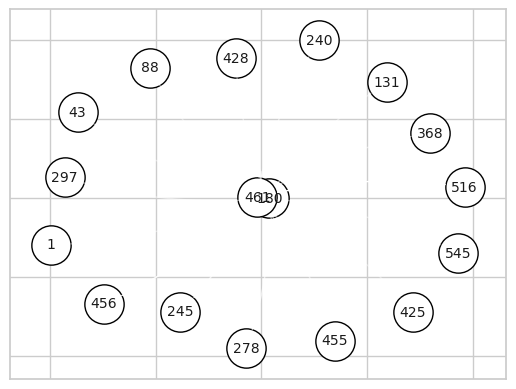

In [38]:
from torch_geometric.explain import Explainer, GNNExplainer


#node id are list of ints from 0 to len(nodes)
#explain node 5
#threshold is top 15 features
top_features = 15
node_to_explain = 5

#use the actual algorithm instead of the higher level Explainer class

xai_model = Explainer(
    model = best_model,
    algorithm = GNNExplainer(epochs=200),
    explanation_type = 'model',
    node_mask_type = 'attributes',
    edge_mask_type = 'object',
    model_config= dict(
                        mode='multiclass_classification',
                        task_level='node',
                        return_type='log_probs',
                      ),
    threshold_config=dict(threshold_type  = 'topk', value = top_features)
                                )


subgraph = xai_model(g.x, g.edge_index, index=node_to_explain)
subgraph.visualize_graph()

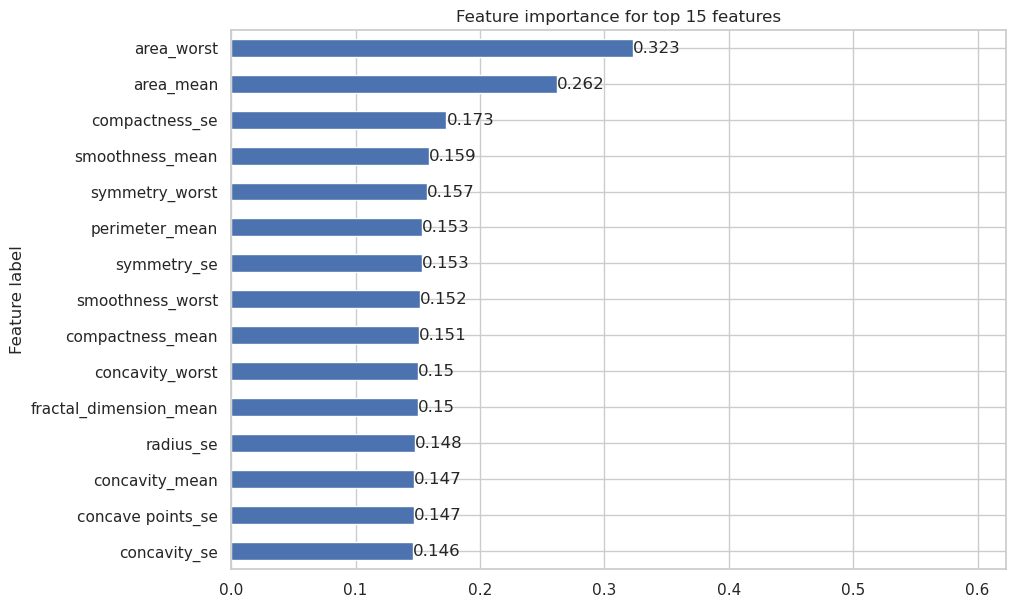

In [21]:
chart = subgraph.visualize_feature_importance(top_k=15, feat_labels = df.columns.to_list())


## Choose Top 10 Nodes based on XAI Values

Since XAI values only rank edge relationships, we can use a centrality metric to gather node-level importance scores (Degree Centrality, Eigenvector centrality.... etc). A higher centrality means that this node is important for message passing, and the edges of the nodes are relevant to the final prediction

We convert to nx subgraph using the generated edge mask as edges, and take a centrality of the graph to get important nodes. 

In [22]:
subgraph

Explanation(node_mask=[569, 30], edge_mask=[323192], prediction=[569, 1], target=[569], index=[1], x=[569, 30], edge_index=[2, 323192])

In [62]:
subgraph.edge_mask.cpu().numpy().max()

0.458017

In [79]:
#convert to NetworkX
from torch_geometric.utils.convert import to_networkx
subgraph_nx = to_networkx(subgraph, edge_attrs = ["edge_mask"])

degree_centrality = subgraph_nx.degree(weight='edge_mask')
degree_centrality = dict(degree_centrality)
degree_centrality

{0: 0.0,
 1: 0.1956385225057602,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.20089437067508698,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.18740227818489075,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96

**now we have node-level importance scores**

In [93]:
rank_list = list(degree_centrality.values())
top10_index = sorted(range(len(rank_list)), key=lambda i: rank_list[i])[-10:]
top10_values = [rank_list[index] for index in top10_index]
df = pd.DataFrame(data = {"importance_score" : top10_values, "node_id" : top10_index})

plt.figure(dpi = 1400, figsize= (10, 8))
sns.set_style('whitegrid')
sns.barplot(data = df, x = "node_id", y = "importance_score")

<Axes: xlabel='node_id', ylabel='importance_score'>